## Exercise 4.1 (4 Points)

### Epipolar Geometry

1. In your own words, explain the following terms:
   - Epipole
   - Epipolar line
   - Epipolar plane


2.  Explain what the epipolar constraint is. Why does a point in one image have a corresponding geometric relationship with the epipolar line in the other view?


3.  In simple terms, describe the role of the fundamental matrix **F**. Why is it important in epipolar geometry, and how does it relate two camera views?


### Answer
Given object `X` and 2 camera `o1` and `o2`. Call the Image plane 1, 2 as the image plane of camera `o1` and `o2` respectiveline. Denote `x1` and `x2` as the image of object `X` on Image plane 1 and 2 respectively.

1.

- Epipoles `e1` and `e2` are image of a camera on image plane of another camera.
- Epipolar plane `pi` is the plane contains 2 cameras and object `X`
- Epipolar lines `l1` and `l2` are the intersection of Epipolar plane with each of image plane.

2. Using the notations above, we define epipolar contraint is that the corresponding point `x'` of image `x1` must lie on the epipolar line `l2` and vice versa.

In the ray `o1X`, all points will result the image `x1` on the Image plane 1. However, each of these points will result different images on Image plane 2. So, the image `x1` relates to the whole epipolar line `l2`.

3. Fundamental matrix `F` shows the relationship between 2 images of the same object in 2 different Image plane. Fundamental matrix is usefull because it enables the full reconstruction. Fundamental matrix includes not only the extrinsic info of the stereo system but also the intrinsic info of each of 2 cameras.

## Exercise 4.2 (4 Points)

### 8-Point Algorithm

In this task you are given two images ("Corridor1.jpg" and "Corridor2.jpg"). 
1) Detect and match features from those images using OpenCv's SIFT detector and OpenCV's BFFMatcher (https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html and https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html)

2) Implement the 8-point algorithm and compute the fundamental matrix. Normalize the 2d points before running the 8-point algorithm. 

3) Validate your results by drawing epipolar lines on image 2 and verify that corresponding points lie on these lines. Explain why this happens.

You can find more resources on epipolar geometry in the course book “Multiple View Geometry in computer vision” by R. Hartley and A. Zisserman.

In [1]:
#1)
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
img1 = cv2.imread('Corridor1.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('Corridor2.jpg', cv2.IMREAD_GRAYSCALE)

# Form matrix T
h, w = img1.shape

T = np.float32([
    [2 / w, 0,      -1],
    [0,     2 / h,  -1],
    [0,     0,      1]
])

#########################
# Detect matching feature
#########################
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

pts1 = []
pts2 = []
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8 * n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

#########################
# 8-point algorithm
#########################
# Build constraint matrix
rows = []
for p1, p2 in zip(pts1, pts2):
    p1 = T @ np.float32([p1[0], p1[1], 1])
    p2 = T @ np.float32([p2[0], p2[1], 1])
    
    rows.append([
        p1[0] * p2[0],
        p1[1] * p2[0],
        p2[0],
        p1[0] * p2[1],
        p1[1] * p2[1],
        p2[1],
        p1[0],
        p1[1],
        1
    ])

A = np.float32(rows)

U, S, Vh = np.linalg.svd(A.T, full_matrices=True)
F = U[:, -1].reshape(3, 3)
U, S, Vh = np.linalg.svd(F, full_matrices=True)
S[2] = 0.0
F = U @ np.diag(S) @ Vh
F = np.transpose(T) @ F @ T

F

array([[-9.5343601e-08,  1.8908904e-06, -2.4821807e-04],
       [-1.7968456e-06, -7.4647474e-08,  1.1005682e-03],
       [ 2.1488382e-04, -1.0813172e-03,  4.4801861e-02]], dtype=float32)

### Draw lines

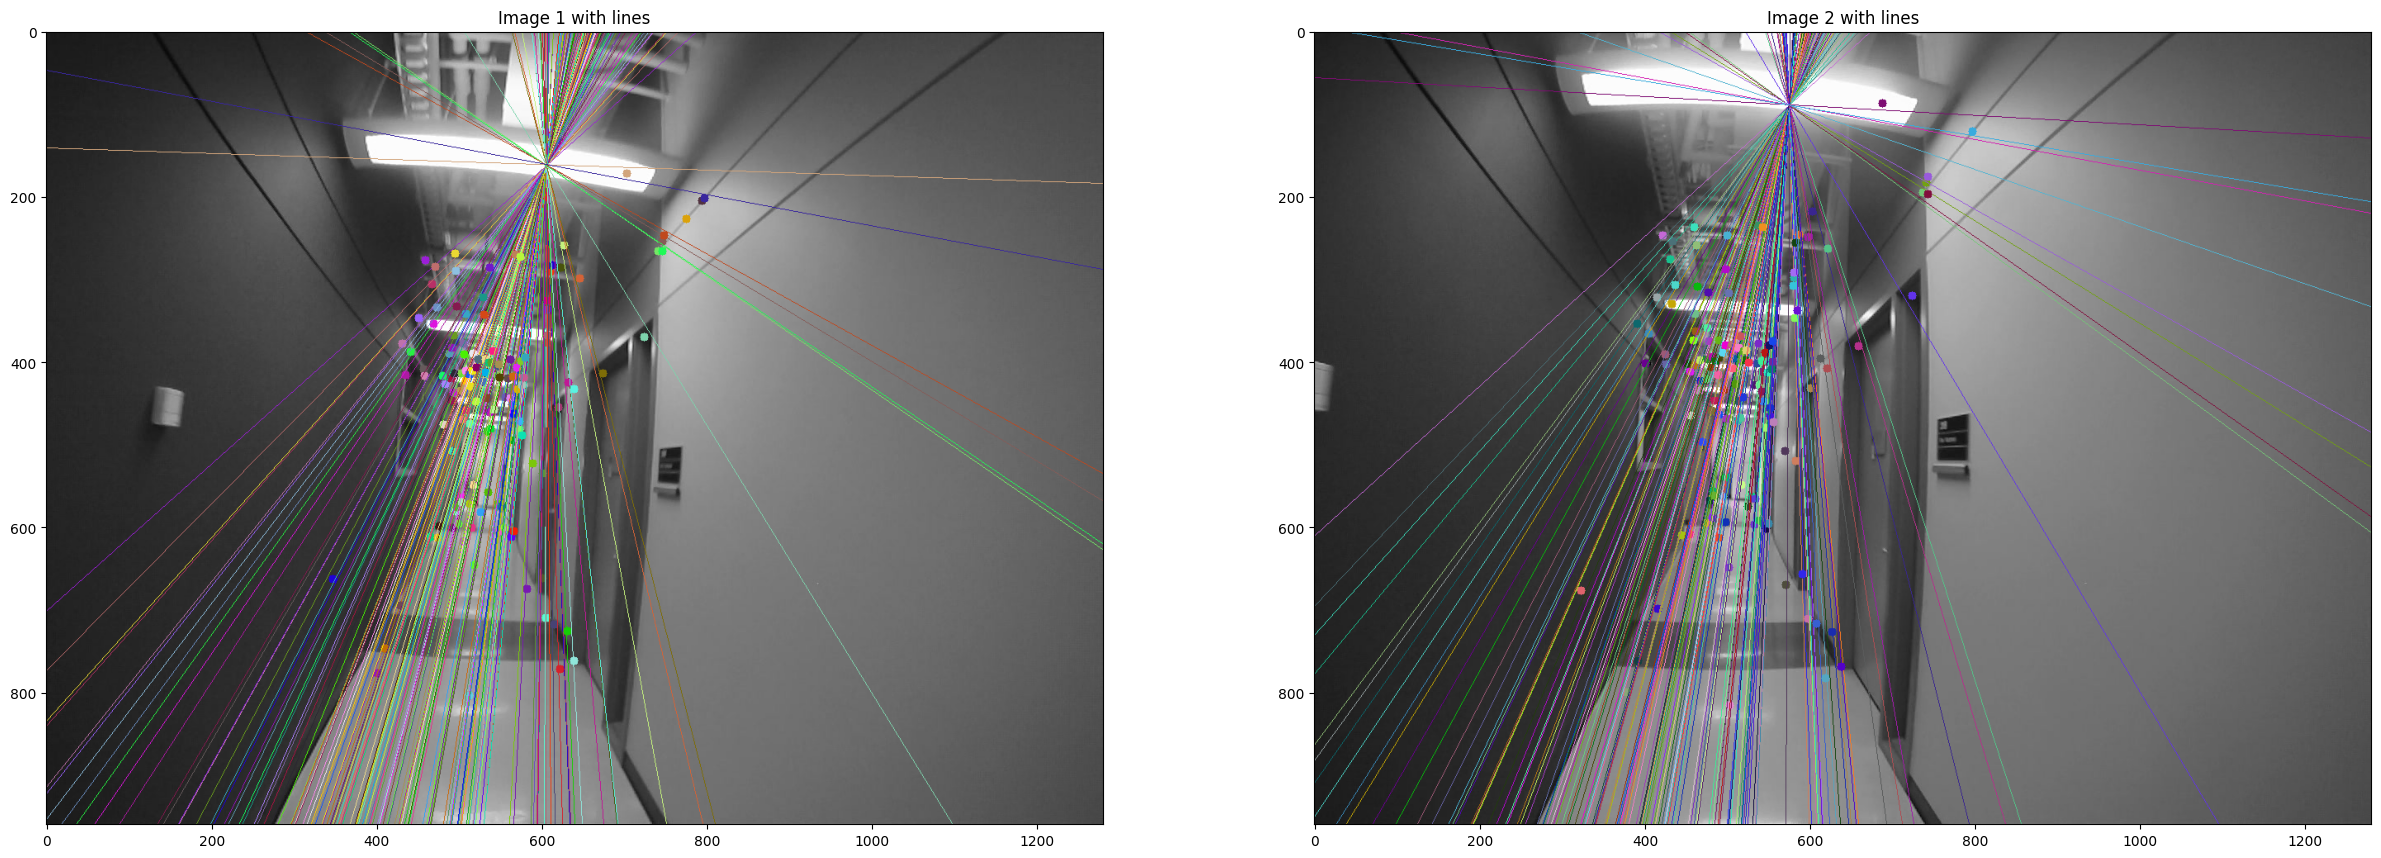

In [2]:
_, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

pts1_ravel = pts1[mask.ravel()==1]
pts2_ravel = pts2[mask.ravel()==1]

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2_ravel.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1_ravel,pts2_ravel)
 
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1_ravel.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2_ravel,pts1_ravel)

fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(121)
ax.imshow(img5)
ax.set_title("Image 1 with lines")

ax = fig.add_subplot(122)
ax.imshow(img3)
ax.set_title("Image 2 with lines")

plt.show()

### Answer

3. We can see that the position of epipole in 2 images are located quite similarly. This is because the cameras' orientation are quite the same and the distance between 2 cameras is small.